<a href="https://colab.research.google.com/github/longer147/NIXTLA-Tutorials/blob/main/Statistical%2C_Machine_Learning_and_Neural_Forecasting_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, you will make forecasts for the M5 dataset choosing the best model for each time series using cross validation.

Statistical, Machine Learning, and Neural Forecasting Methods In this tutorial, we will explore the process of forecasting on the M5 dataset by utilizing the most suitable model for each time series. We’ll accomplish this through an essential technique known as cross-validation. This approach helps us in estimating the predictive performance of our models, and in selecting the model that yields the best performance for each time series.

The M5 dataset comprises of hierarchical sales data, spanning five years, from Walmart. The aim is to forecast daily sales for the next 28 days. The dataset is broken down into the 50 states of America, with 10 stores in each state.

In the realm of time series forecasting and analysis, one of the more complex tasks is identifying the model that is optimally suited for a specific group of series. Quite often, this selection process leans heavily on intuition, which may not necessarily align with the empirical reality of our dataset.

In this tutorial, we aim to provide a more structured, data-driven approach to model selection for different groups of series within the M5 benchmark dataset. This dataset, well-known in the field of forecasting, allows us to showcase the versatility and power of our methodology.

We will train an assortment of models from various forecasting paradigms:

StatsForecast

Baseline models: These models are simple yet often highly effective for providing an initial perspective on the forecasting problem. We will use SeasonalNaive and HistoricAverage models for this category.
Intermittent models: For series with sporadic, non-continuous demand, we will utilize models like CrostonOptimized, IMAPA, and ADIDA. These models are particularly suited for handling zero-inflated series.
State Space Models: These are statistical models that use mathematical descriptions of a system to make predictions. The AutoETS model from the statsforecast library falls under this category.
MLForecast

Machine Learning: Leveraging ML models like LightGBM, XGBoost, and LinearRegression can be advantageous due to their capacity to uncover intricate patterns in data. We’ll use the MLForecast library for this purpose.

NeuralForecast

Deep Learning: DL models, such as Transformers (AutoTFT) and Neural Networks (AutoNHITS), allow us to handle complex non-linear dependencies in time series data. We’ll utilize the NeuralForecast library for these models.

Using the Nixtla suite of libraries, we’ll be able to drive our model selection process with data, ensuring we utilize the most suitable models for specific groups of series in our dataset.

Outline:

Reading Data: In this initial step, we load our dataset into memory, making it available for our subsequent analysis and forecasting. It is important to understand the structure and nuances of the dataset at this stage.

Forecasting Using Statistical and Deep Learning Methods: We apply a wide range of forecasting methods from basic statistical techniques to advanced deep learning models. The aim is to generate predictions for the next 28 days based on our dataset.

Model Performance Evaluation on Different Windows: We assess the performance of our models on distinct windows.

Selecting the Best Model for a Group of Series: Using the performance evaluation, we identify the optimal model for each group of series. This step ensures that the chosen model is tailored to the unique characteristics of each group.

Filtering the Best Possible Forecast: Finally, we filter the forecasts generated by our chosen models to obtain the most promising predictions. This is our final output and represents the best possible forecast for each series according to our models.

Warning

This tutorial was originally executed using a c5d.24xlarge EC2 instance.

In [11]:
!pip install statsforecast mlforecast neuralforecast datasetsforecast s3fs pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 69.7 MB/s eta 0:00:00



Download and prepare data
The example uses the M5 dataset. It consists of 30,490 bottom time series.

In [12]:
import pandas as pd
# Load the training target dataset from the provided URL
Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')

# Rename columns to match the Nixtlaverse's expectations
# The 'item_id' becomes 'unique_id' representing the unique identifier of the time series
# The 'timestamp' becomes 'ds' representing the time stamp of the data points
# The 'demand' becomes 'y' representing the target variable we want to forecast
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id',
    'timestamp': 'ds',
    'demand': 'y'
})

# Convert the 'ds' column to datetime format to ensure proper handling of date-related operations in subsequent steps
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

For simplicity sake we will keep just one category

In [13]:
Y_df = Y_df.query('unique_id.str.startswith("FOODS_3")').reset_index(drop=True)

Y_df['unique_id'] = Y_df['unique_id'].astype(str)

Basic Plotting
Plot some series using the plot method from the StatsForecast class. This method prints 8 random series from the dataset and is useful for basic EDA.

In [14]:
from statsforecast import StatsForecast
from tqdm.autonotebook import tqdm

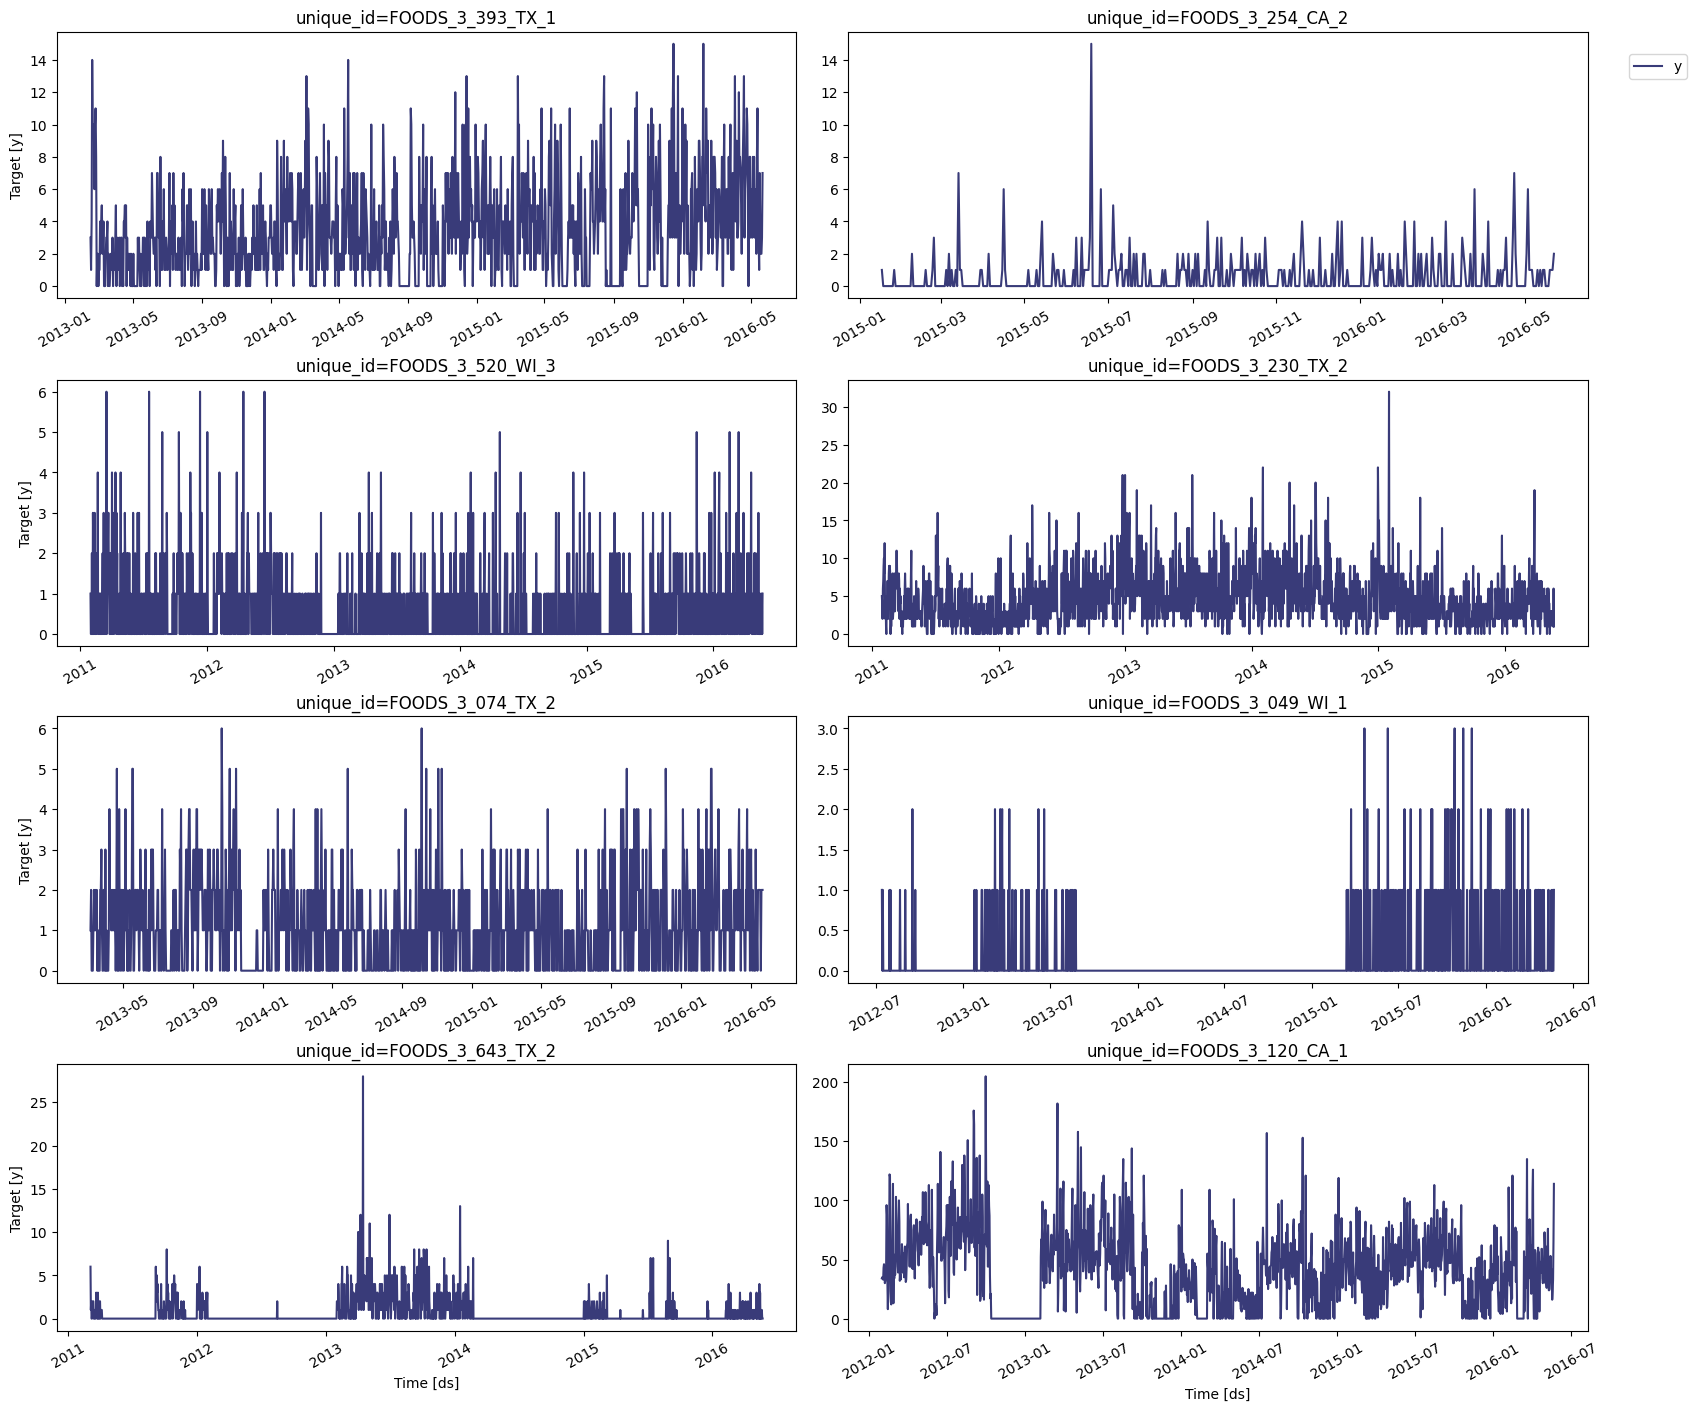

In [15]:
# Feature: plot random series for EDA
StatsForecast.plot(Y_df)

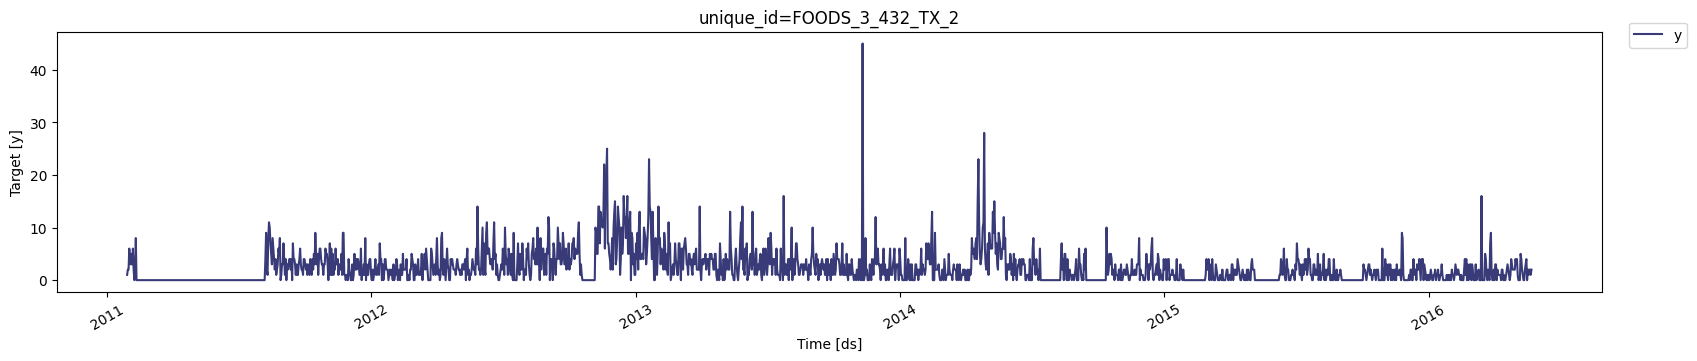

In [16]:
# Feature: plot groups of series for EDA
StatsForecast.plot(Y_df, unique_ids=["FOODS_3_432_TX_2"])

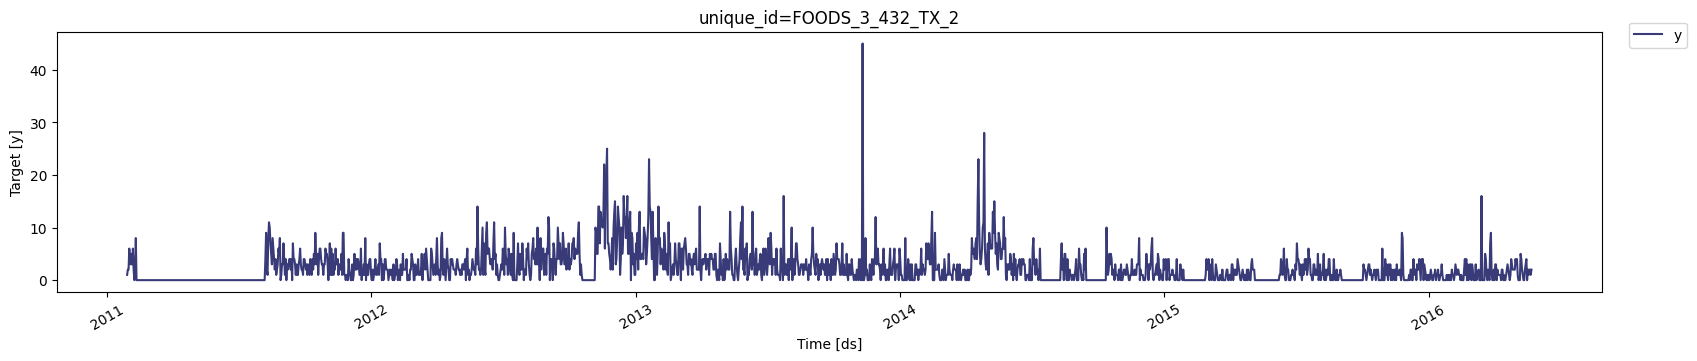

In [17]:
# Feature: plot groups of series for EDA
StatsForecast.plot(Y_df, unique_ids=["FOODS_3_432_TX_2"], engine ='matplotlib')

Create forecasts with Stats, Ml and Neural methods.
​
StatsForecast
StatsForecast is a comprehensive library providing a suite of popular univariate time series forecasting models, all designed with a focus on high performance and scalability.

Here’s what makes StatsForecast a powerful tool for time series forecasting:

Collection of Local Models: StatsForecast provides a diverse collection of local models that can be applied to each time series individually, allowing us to capture unique patterns within each series.

Simplicity: With StatsForecast, training, forecasting, and backtesting multiple models become a straightforward process, requiring only a few lines of code. This simplicity makes it a convenient tool for both beginners and experienced practitioners.

Optimized for Speed: The implementation of the models in StatsForecast is optimized for speed, ensuring that large-scale computations are performed efficiently, thereby reducing the overall time for model training and prediction.

Horizontal Scalability: One of the distinguishing features of StatsForecast is its ability to scale horizontally. It is compatible with distributed computing frameworks such as Spark, Dask, and Ray. This feature allows it to handle large datasets by distributing the computations across multiple nodes in a cluster, making it a go-to solution for large-scale time series forecasting tasks.

StatsForecast receives a list of models to fit each time series. Since we are dealing with Daily data, it would be benefitial to use 7 as seasonality.

In [18]:
# Import necessary models from the statsforecast library
from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive,
    # Naive: A simple model that uses the last observed value as the forecast
    Naive,
    # HistoricAverage: This model uses the average of all historical data as the forecast
    HistoricAverage,
    # CrostonOptimized: A model specifically designed for intermittent demand forecasting
    CrostonOptimized,
    # ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand
    ADIDA,
    # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation
    IMAPA,
    # AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    AutoETS
)

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.
freq: a string indicating the frequency of the data. (See panda’s available frequencies.)
n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.
fallback_model: a model to be used if a model fails. Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [19]:
horizon = 28
models = [
    SeasonalNaive(season_length=7),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=7)
]

In [20]:
# Instantiate the StatsForecast class
sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq='D',  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

The forecast method takes two arguments: forecasts next h (horizon) and level.

h (int): represents the forecast h steps into the future. In this case, 12 months ahead.
level (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, level=[90] means that the model expects the real value to be inside that interval 90% of the times.
The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This block of code times how long it takes to run the forecasting function of the StatsForecast class, which predicts the next 28 days (h=28). The level is set to [90], meaning it will compute the 90% prediction interval. The time is calculated in minutes and printed out at the end.

In [24]:
from time import time
from statsforecast.utils import ConformalIntervals

# Get the current time before forecasting starts
init = time()

# Instantiate ConformalIntervals object
prediction_intervals = ConformalIntervals(h=28)

# Call the forecast method with prediction_intervals object
fcst_df = sf.forecast(
    df=Y_df,
    h=28,
    prediction_intervals=prediction_intervals,
    level=[90]
)

# Get the current time after the forecasting ends
end = time()

# Calculate and print the total time taken for the forecasting in minutes
print(f'Forecast Minutes: {(end - init) / 60}')

KeyboardInterrupt: 

In [ ]:
Forecast Minutes: 2.270755163828532

In [ ]:
fcst_df.head()

MLForecast
MLForecast is a powerful library that provides automated feature creation for time series forecasting, facilitating the use of global machine learning models. It is designed for high performance and scalability.

Key features of MLForecast include:

Support for sklearn models: MLForecast is compatible with models that follow the scikit-learn API. This makes it highly flexible and allows it to seamlessly integrate with a wide variety of machine learning algorithms.

Simplicity: With MLForecast, the tasks of training, forecasting, and backtesting models can be accomplished in just a few lines of code. This streamlined simplicity makes it user-friendly for practitioners at all levels of expertise.

Optimized for speed: MLForecast is engineered to execute tasks rapidly, which is crucial when handling large datasets and complex models.

Horizontal Scalability: MLForecast is capable of horizontal scaling using distributed computing frameworks such as Spark, Dask, and Ray. This feature enables it to efficiently process massive datasets by distributing the computations across multiple nodes in a cluster, making it ideal for large-scale time series forecasting tasks.

In [ ]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean

In [ ]:
!pip install lightgbm xgboost

In [ ]:
# Import the necessary models from various libraries

# LGBMRegressor: A gradient boosting framework that uses tree-based learning algorithms from the LightGBM library
from lightgbm import LGBMRegressor

# XGBRegressor: A gradient boosting regressor model from the XGBoost library
from xgboost import XGBRegressor

# LinearRegression: A simple linear regression model from the scikit-learn library
from sklearn.linear_model import LinearRegression

To use MLForecast for time series forecasting, we instantiate a new MLForecast object and provide it with various parameters to tailor the modeling process to our specific needs:

models: This parameter accepts a list of machine learning models you wish to use for forecasting. You can import your preferred models from scikit-learn, lightgbm and xgboost.

freq: This is a string indicating the frequency of your data (hourly, daily, weekly, etc.). The specific format of this string should align with pandas’ recognized frequency strings.

target_transforms: These are transformations applied to the target variable before model training and after model prediction. This can be useful when working with data that may benefit from transformations, such as log-transforms for highly skewed data.

lags: This parameter accepts specific lag values to be used as regressors. Lags represent how many steps back in time you want to look when creating features for your model. For example, if you want to use the previous day’s data as a feature for predicting today’s value, you would specify a lag of 1.

lags_transforms: These are specific transformations for each lag. This allows you to apply transformations to your lagged features.

date_features: This parameter specifies date-related features to be used as regressors. For instance, you might want to include the day of the week or the month as a feature in your model.

num_threads: This parameter controls the number of threads to use for parallelizing feature creation, helping to speed up this process when working with large datasets.

All these settings are passed to the MLForecast constructor. Once the MLForecast object is initialized with these settings, we call its fit method and pass the historical data frame as the argument. The fit method trains the models on the provided historical data, readying them for future forecasting tasks.

In [ ]:
# Instantiate the MLForecast object
mlf = MLForecast(
    models=[LGBMRegressor(), XGBRegressor(), LinearRegression()],  # List of models for forecasting: LightGBM, XGBoost and Linear Regression
    freq='D',  # Frequency of the data - 'D' for daily frequency
    lags=list(range(1, 7)),  # Specific lags to use as regressors: 1 to 6 days
    lag_transforms = {
        1:  [expanding_mean],  # Apply expanding mean transformation to the lag of 1 day
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],  # Date features to use as regressors
)

Just call the fit models to train the select models. In this case we are generating conformal prediction intervals.

In [ ]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(Y_df, prediction_intervals=PredictionIntervals(window_size=28))

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')

In [ ]:
MLForecast Minutes: 2.2809854547182717

After that, just call predict to generate forecasts.

In [ ]:
fcst_mlf_df = mlf.predict(28, level=[90])

In [ ]:
fcst_mlf_df.head()

NeuralForecast
NeuralForecast is a robust collection of neural forecasting models that focuses on usability and performance. It includes a variety of model architectures, from classic networks such as Multilayer Perceptrons (MLP) and Recurrent Neural Networks (RNN) to novel contributions like N-BEATS, N-HITS, Temporal Fusion Transformers (TFT), and more.

Key features of NeuralForecast include:

A broad collection of global models. Out of the box implementation of MLP, LSTM, RNN, TCN, DilatedRNN, NBEATS, NHITS, ESRNN, TFT, Informer, PatchTST and HINT.
A simple and intuitive interface that allows training, forecasting, and backtesting of various models in a few lines of code.
Support for GPU acceleration to improve computational speed.
This machine doesn’t have GPU, but Google Colabs offers some for free.

Using Colab’s GPU to train NeuralForecast.

In [ ]:
# Read the results from Colab
fcst_nf_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/forecast-nf.parquet')

In [ ]:
fcst_nf_df.head()

In [ ]:
# Merge the forecasts from StatsForecast and NeuralForecast
fcst_df = fcst_df.merge(fcst_nf_df, how='left', on=['unique_id', 'ds'])

# Merge the forecasts from MLForecast into the combined forecast dataframe
fcst_df = fcst_df.merge(fcst_mlf_df, how='left', on=['unique_id', 'ds'])

In [ ]:
fcst_df.head()

Forecast plots

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)

Use the plot function to explore models and ID’s

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3,
        models=['CrostonOptimized', 'AutoNHITS', 'SeasonalNaive', 'LGBMRegressor'])

Validate Model’s Performance
The three libraries - StatsForecast, MLForecast, and NeuralForecast - offer out-of-the-box cross-validation capabilities specifically designed for time series. This allows us to evaluate the model’s performance using historical data to obtain an unbiased assessment of how well each model is likely to perform on unseen data.

Cross Validation in StatsForecast
The cross_validation method from the StatsForecast class accepts the following arguments:

df: A DataFrame representing the training data.
h (int): The forecast horizon, represented as the number of steps into the future that we wish to predict. For example, if we’re forecasting hourly data, h=24 would represent a 24-hour forecast.
step_size (int): The step size between each cross-validation window. This parameter determines how often we want to run the forecasting process.
n_windows (int): The number of windows used for cross validation. This parameter defines how many past forecasting processes we want to evaluate.
These parameters allow us to control the extent and granularity of our cross-validation process. By tuning these settings, we can balance between computational cost and the thoroughness of the cross-validation.

In [ ]:
init = time()
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=3, step_size=horizon, level=[90])
end = time()
print(f'CV Minutes: {(end - init) / 60}')

In [ ]:
CV Minutes: 5.206169327100118

The crossvaldation_df object is a new data frame that includes the following columns:

unique_id index: (If you dont like working with index just run forecasts_cv_df.resetindex())
ds: datestamp or temporal index
cutoff: the last datestamp or temporal index for the n_windows. If n_windows=1, then one unique cuttoff value, if n_windows=2 then two unique cutoff values.
y: true value
"model": columns with the model’s name and fitted value.

In [ ]:
cv_df.head()

MLForecast
The cross_validation method from the MLForecast class takes the following arguments.

data: training data frame
window_size (int): represents h steps into the future that are being forecasted. In this case, 24 hours ahead.
step_size (int): step size between each window. In other words: how often do you want to run the forecasting processes.
n_windows (int): number of windows used for cross-validation. In other words: what number of forecasting processes in the past do you want to evaluate.
prediction_intervals: class to compute conformal intervals.

In [ ]:
init = time()
cv_mlf_df = mlf.cross_validation(
    data=Y_df,
    window_size=horizon,
    n_windows=3,
    step_size=horizon,
    level=[90],
)
end = time()
print(f'CV Minutes: {(end - init) / 60}')

The crossvaldation_df object is a new data frame that includes the following columns:

unique_id index: (If you dont like working with index just run forecasts_cv_df.resetindex())
ds: datestamp or temporal index
cutoff: the last datestamp or temporal index for the n_windows. If n_windows=1, then one unique cuttoff value, if n_windows=2 then two unique cutoff values.
y: true value
"model": columns with the model’s name and fitted value.

In [ ]:
cv_mlf_df.head()

NeuralForecast
This machine doesn’t have GPU, but Google Colabs offers some for free.

Using Colab’s GPU to train NeuralForecast.

In [ ]:
cv_nf_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/cross-validation-nf.parquet')

In [ ]:
cv_nf_df.head()


Merge cross validation forecasts

In [ ]:
cv_df = cv_df.merge(cv_nf_df.drop(columns=['y']), how='left', on=['unique_id', 'ds', 'cutoff'])
cv_df = cv_df.merge(cv_mlf_df.drop(columns=['y']), how='left', on=['unique_id', 'ds', 'cutoff'])

Plots CV

In [ ]:
cutoffs = cv_df['cutoff'].unique()

In [ ]:
for cutoff in cutoffs:
    img = sf.plot(
        Y_df,
        cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
        max_insample_length=28 * 5,
        unique_ids=['FOODS_3_001_CA_1'],
    )
    img.show()

Aggregate Demand

In [ ]:
agg_cv_df = cv_df.loc[:,~cv_df.columns.str.contains('hi|lo')].groupby(['ds', 'cutoff']).sum(numeric_only=True).reset_index()
agg_cv_df.insert(0, 'unique_id', 'agg_demand')

In [ ]:
agg_Y_df = Y_df.groupby(['ds']).sum(numeric_only=True).reset_index()
agg_Y_df.insert(0, 'unique_id', 'agg_demand')

In [ ]:
for cutoff in cutoffs:
    img = sf.plot(
        agg_Y_df,
        agg_cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
        max_insample_length=28 * 5,
    )
    img.show()

Evaluation per series and CV window
In this section, we will evaluate the performance of each model for each time series and each cross validation window. Since we have many combinations, we will use dask to parallelize the evaluation. The parallelization will be done using fugue.

In [ ]:
from typing import List, Callable

from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine
from datasetsforecast.losses import mse, mae, smape

The evaluate function receives a unique combination of a time series and a window, and calculates different metrics for each model in df.

In [ ]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [ ]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

Let’s cleate a dask client.

In [ ]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

The transform function takes the evaluate functions and applies it to each combination of time series (unique_id) and cross validation window (cutoff) using the dask client we created before.

In [ ]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')],
    evaluate,
    engine="dask",
    params={'metrics': [mse, mae, smape]},
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}",
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)

In [ ]:
evaluation_df.head()

In [ ]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Results showed in previous experiments.

model	MSE
MQCNN	10.09
DeepAR-student_t	10.11
DeepAR-lognormal	30.20
DeepAR	9.13
NPTS	11.53
Top 3 models: DeepAR, AutoNHITS, AutoETS.

In [ ]:
!pip install seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

In [ ]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

Choose models for groups of series
Feature:

A unified dataframe with forecasts for all different models
Easy Ensamble
E.g. Average predictions
Or MinMax (Choosing is ensembling)

In [ ]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')

Et pluribus unum: an inclusive forecasting Pie.

In [ ]:
# For the mse, calculate how many times a model wins
eval_series_df = evaluation_df.query('metric == "mse"').groupby(['unique_id']).mean(numeric_only=True)
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)
counts_series = eval_series_df.value_counts('best_model')
plt.pie(counts_series, labels=counts_series.index, autopct='%.0f%%')
plt.show()

In [ ]:
sf.plot(Y_df, cv_df.drop(columns=['cutoff', 'y']),
        max_insample_length=28 * 6,
        models=['AutoNHITS'],
        unique_ids=eval_series_df.query('best_model == "AutoNHITS"').index[:8])

Choose Forecasting method for different groups of series

In [ ]:
# Merge the best model per time series dataframe
# and filter the forecasts based on that dataframe
# for each time series
fcst_df = pd.melt(fcst_df.set_index('unique_id'), id_vars=['ds'], var_name='model', value_name='forecast', ignore_index=False)
fcst_df = fcst_df.join(eval_series_df[['best_model']])
fcst_df[['model', 'pred-interval']] = fcst_df['model'].str.split('-', expand=True, n=1)
fcst_df = fcst_df.query('model == best_model')
fcst_df['name'] = [f'forecast-{x}' if x is not None else 'forecast' for x in fcst_df['pred-interval']]
fcst_df = pd.pivot_table(fcst_df, index=['unique_id', 'ds'], values=['forecast'], columns=['name']).droplevel(0, axis=1).reset_index()

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)

Technical Debt
Train the statistical models in the full dataset.
Increase the number of num_samples in the neural auto models.
Include other models such as Theta, ARIMA, RNN, LSTM, …

Further materials
Available Models StatsForecast
Available Models NeuralForecast
Scalers and Loss Functions
Getting Started NeuralForecast
Hierarchical Reconciliation
Distributed ML Forecast (trees)
Using StatsForecast to train millions of time series
Intermittent Demand Forecasting With Nixtla on Databricks